# Introduction

In this note, I will introduce two basic text feature extration methods.
- tf-idf
- Bag of words (BOW)

# Raw data

First we need to get some raw text data. We use the [Review polarity v2.0](http://www.cs.cornell.edu/people/pabo/movie-review-data/) data set created by Bo Pang and Lillian Lee at Cornell University. It consists of 2000 movie reviews, 1000 of which are positive and 1000 are negative.

In [2]:
data_url = "http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"
fn = data_url.split("/")[-1]

import urllib.request
urllib.request.urlretrieve(data_url, fn)
t!ar zxf review_polarity.tar.gz
!ls

poldata.README.2.0  review_polarity.tar.gz  sample_data  txt_sentoken


## Reading the data

Read the whole datasets:

In [4]:
import os
filenames = list()
for root, dirs, files in os.walk("./txt_sentoken"):
  # Python method walk() generates the files names
  # in a directory tree by walking the tree either
  # top-down or bottom-up
  for names in files:
    filenames.append(os.path.join(root, names))
print(f"The number of files is {len(filenames)}.")

The number of files is 2000.


Then we need to use all the address to read the text.

In [5]:
import random
import numpy as np

X_txt = list()
y = list()
random.shuffle(filenames)
for i, fn in enumerate(filenames):
  if fn.find("/pos/") > 0:
    msg = "positive"
    y.append(1)
  else:
    msg = "negative"
    y.append(-1)
  with open(fn, encoding="utf-8") as f:
    X_txt.append(f.read())
  if i < 10:
    print(fn, msg, "example")
y = np.asarray(y)
assert len(X_txt) == y.shape[0]

./txt_sentoken/pos/cv919_16380.txt positive example
./txt_sentoken/pos/cv428_11347.txt positive example
./txt_sentoken/pos/cv999_13106.txt positive example
./txt_sentoken/neg/cv354_8573.txt negative example
./txt_sentoken/pos/cv464_15650.txt positive example
./txt_sentoken/neg/cv922_10185.txt negative example
./txt_sentoken/pos/cv406_21020.txt positive example
./txt_sentoken/neg/cv559_0057.txt negative example
./txt_sentoken/neg/cv589_12853.txt negative example
./txt_sentoken/pos/cv417_13115.txt positive example


We can see what we get in the `X_txt`.

In [8]:
X_txt[:3]

['when i first heard that kevin costner was making a movie called " the postman , " i thought , " an american version of \'il postino ? \' \nstarring costner ? \ngod help us ! " \nwhen i found out that it was not a remake of " postino " but an postapocalyptic epic , i thought , " \'landworld ? \' \nplease , god , make him stop ! " \nas it turns out , " the postman " is a much better film than i had expected . \ndespite being set in 2013 , the movie is , at heart , a western : a band of thugs terrorizes peaceful villagers ; a wandering hero opposes the bandits and inspires others to fight back . \nthe setting , however , allows that familiar plot to take on greater significance : american society has collapsed due to plagues and wars , and survivors live behind barracades in isolated villages . \nthe struggle of a dead society to be reborn has a grand quality and deserves the epic scale costner grants it . \ncostner\'s nameless character , a wandering actor , rides in from the vast wast

We can find a histogram over the length of the reviews.

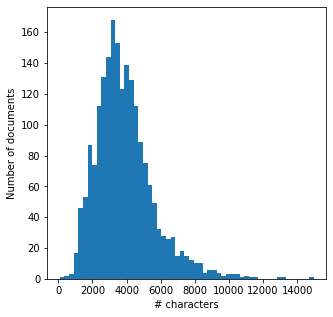

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.hist([len(x) for x in X_txt], 55)
plt.xlabel("# characters")
plt.ylabel("Number of documents")
plt.show()

# Data preprocessing

## Tokenization

Here I use nltk to tokenize our data.

In [17]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

txt_tok = []
for sent in X_txt:
  txt_tok.append(word_tokenize(sent))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Remove Stopwords and Punctuation

In [36]:
import string
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
punct = string.punctuation
txt_tok_re = []
sent = []
voc = []
for se in txt_tok:
  sent = []
  for word in se:
    if word not in stopwords and word not in punct:
      sent.append(word.lower())
      if word not in voc:
        voc.append(word.lower())
  txt_tok_re.append(sent)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Then we can get our clean text data and the vocabulary `voc`.

In [0]:
voc.append('<unk>')
random.shuffle(voc)
voc = dict([(word, i) for i, word in enumerate(voc)])

In [101]:
voc['dolphin']

8753

# Feature Extraction

## ti-idf

**Tf-idf** stands for term frequency-inverse document frequency. It's a technique to measure how important a word to a document in a corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

### Term Frequency

Measure the number of times a word in a document.
$$
\begin{equation}
t_{ij}=\frac{n_{ij}}{\sum_k n_{kj}}.
\end{equation}
$$
This represents that the term frequency of word $w_i$ in document $d_j$.

### Inverse Document Frequency

If a word appear many times in the corpus, it's less important in a document.
$$
\begin{equation}
idf_i=\log\left(\frac{|D|}{|{j,t_i\in d_j}|+1}\right).
\end{equation}
$$
$|D|$ is the number of documents. $|j, t_i\in d_j|$ means the number of documents that contains word $t_i$.

### Python Implementation

First, we need to compute the idf for each word in the vocabulary.

In [0]:
idf = dict()
for word in voc:
  idf[word] = 0
  for sent in txt_tok_re:
    if word in sent:
      idf[word] += 1
      break

In [0]:
for word in idf:
  idf[word] = np.log(2000 / (idf[word] + 1))

Then we compute the **tfidf** vector for each document.

In [0]:
from collections import Counter
X_vector = np.zeros((2000, len(voc)))
for i in range(2000):
  sent = txt_tok_re[i]
  c = Counter(sent)
  for word in c:
    X_vector[i, voc[word]] = c[word] / len(sent) * idf[word]

Then we can use **Logistic Regression** to test our **tfidf** vector.

In [83]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression().fit(X_vector, y)
LR.score(X_vector, y)

0.832

### Sklearn Implementation

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stopwords)
tfidf.fit(X_txt)
X = tfidf.transform(X_txt)

Then we can use **Logistic Regression** to test our **tfidf** vector.

In [97]:
LR = LogistiRegression().fit(X, y)
LR.score(X, y)

0.977

## BOW

**Bag-of-word** is a really simple feature extraction method. It just transforms a text to a one-hot vector.

### Python Implementation

In [0]:
X_bow = np.zeros((len(txt_tok_re), len(voc)))
for sent_i in range(len(txt_tok_re)):
    for word in txt_tok_re[sent_i]:
        X_bow[sent_i, voc[word]] = 1

Then we can use **Logistic Regression** to test our **BOW** vector.

In [105]:
LR = LogisticRegression().fit(X_bow, y)
LR.score(X_bow, y)

1.0

### Sklearn Implementation

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(stop_words=stopwords)
bow.fit(X_txt)
X = bow.transform(X_txt)

In [107]:
LR = LogisticRegression().fit(X, y)
LR.score(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1.0